# Bob and Alice Go to a Bar

## Problem

Bob and Alice want to meet in a bar, but Bob left his phone at
home. There are two bars, which Bob and Alice visit with
different frequencies. Which bar Bob and Alice should head if
they want to meet?

In [1]:
using Plots, Gen, Memoize

## Generative model 

Consider Alice's model (Bob's model is obtained by swapping 'Bob' and 'Alice').
The optimal probability of Alice's choice with respect to the bars is given
(observed with high confidence or proclaimed by an oracle). To
complete the formulation, we also need to specify the probability
of Alice choosing to visit the bar where Bob is heading, provided  Alice 
knows Bob's plans and
would otherwise visit either bar with equal probability. This results in the following generative model:

\begin{equation}
    \begin{aligned}
       \mathbb{I}_{Bob}^1 & \gets \mathrm{Bernoulli}\left(\hat p_{Bob}^1\right) \\
       \hline 
        \mathbb{I}_{Alice}^1  & \sim \mathrm{Bernoulli}\left(p_{Alice}^1\right) \\
        \mathbb{I}_{Bob}^1  & \sim \mathrm{Bernoulli}\left(\mathbb{I}_{Alice}^1 p_{Alice}^m + \left(1 - \mathbb{I}_{Alice}^1\right)\left(1 - p_{Alice}^m\right)\right)
    \end{aligned}
\end{equation}

## Stochastic conditioning

The model is stochastically conditioned on the perceived distribution of Bob's choices.
Gen does not support stochastic conditioning, hence we need to write down the formula for the joint probability explicitly.

\begin{equation}
    \log \Pr\left[\mathbb{I}_{Alice}^1\right] = \begin{cases}
                 \log p_{Alice}^1 + \hat p_{Bob}^1\log p_{Alice}^m + \left(1 - \hat p_{Bob}^1\right)\log \left(1 - p_{Alice}^m\right) & \text{if }\mathbb{I}_{Alice}^1 \\
        \log \left(1 - p_{Alice}^1\right) + \hat p_{Bob}^1\log \left(1 - p_{Alice}^m\right) + \left(1 - \hat p_{Bob}^1\right)\log p_{Alice}^m & \text{otherwise}
\end{cases}
\end{equation}




In [2]:
struct Agent
    name::String
    p1::Real
    pm::Real
end;

"Computes conditional log-probability of agent's choice"
function logp(a::Agent, q::Real, I1::Bool)
    if I1
        q * log(a.pm) + (1 - q)*log(1 - a.pm)
    else
        q * log(1 - a.pm) + (1 - q)*log(a.pm)
    end
end;

The Gen model implements the generative model of an agent. Stochastic conditioning is emulated by through closed-form computation of the log probability and factoring the trace (using the Bernoulli trick).

## Gen Model and Inference

In [3]:
@gen function model(me::Agent, buddy::Agent, depth::Int, niter::Int)
    if depth > 0
        J1s = run_model(buddy, me, depth-1, niter)
        q = sum(J1s)/length(J1s)
    else
        q = 0.5
    end
    
    I1 = @trace(bernoulli(me.p1), :I1)
    
    # Stochastic conditioning, emulated
    @trace(bernoulli(exp(logp(me, q, I1))), :logp)
end;

Epistemic reasoning involves recusrive inference calls, with exponential time complexity in naive implementation. Memoizing the inference calls results in linear complexity in the deliberation depth.

In [4]:
@memoize function run_model(me::Agent, buddy::Agent, depth::Int, niter=1000)
    observations = Gen.choicemap()
    observations[:logp] = true

    trace, _ = Gen.generate(model, (me, buddy, depth, niter), observations)
    J1s = []
    for i = 1:niter
        trace, _ = Gen.mh(trace, select(:I1))
        push!(J1s, get_choices(trace)[:I1])
    end
    return J1s
end
empty!(memoize_cache(run_model));

Based on the model and inference, we can define an agent, representing either Alice or Bob.

In [5]:
function genagent(me, buddy, depth, niter=10000)
    nburn = niter%10
    I1s = run_model(me, buddy, depth, nburn + niter)[nburn+1:end]
    return sum(I1s)/length(I1s)
end;

## Experiments

We simulate interactions between Bob and Alice at different depths of epistemic reasoning.

In [6]:
function plot_p1(me, buddy; agent=genagent, at="gen", n=10)
    probs1 = [agent(me, buddy, i) for i in 0:n];
    probs2 = [agent(buddy, me, i) for i in 0:n];
    p = plot(probs1, xlabel="depth", ylabel="p₁", label=me.name, ylim=(0, 1))
    plot!(p, probs2, label=buddy.name)
    savefig(p, "figures/ba-$at-$(me.p1)-$(me.pm)-$(buddy.p1)-$(buddy.pm).pdf")
    p
end

plot_p1 (generic function with 1 method)

### Bob and Alice Want to Meet 

#### Bob and Alice Like the Same Bar

When Bob and Alice have the same preferences, it is easy to coordinate.

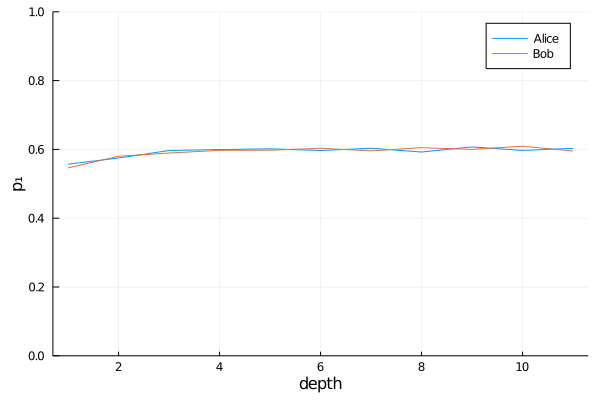

In [8]:
p = plot_p1(Agent("Alice", 0.55, 0.75), Agent("Bob", 0.55, 0.75))

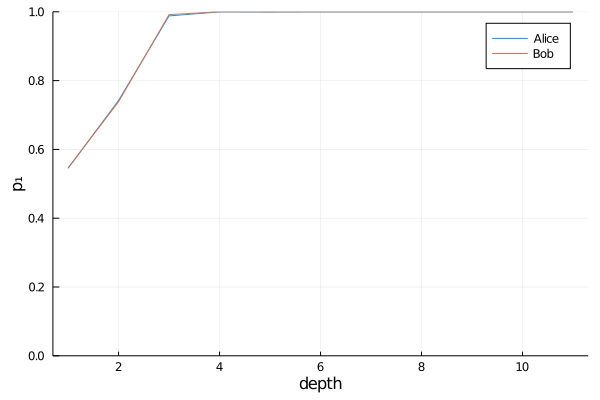

In [27]:
plot_p1(Agent("Alice", 0.55, 0.9999), Agent("Bob", 0.55, 0.9999))

#### Bob and Alice Like Different Bars

When the bar preferences are exactly opposite, it is hard for Bob and Alice to meet.

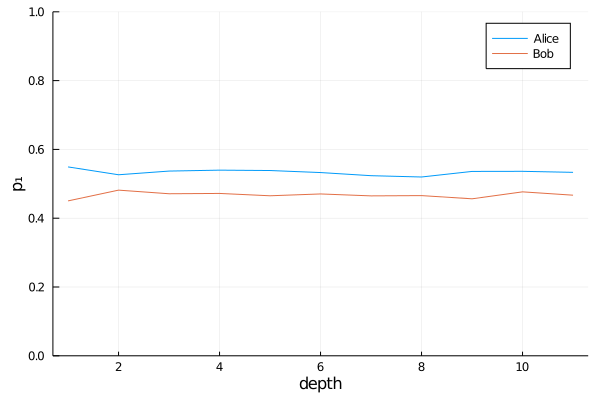

In [10]:
plot_p1(Agent("Alice", 0.55, 0.75), Agent("Bob", 0.45, 0.75))

However, when ties are broken, deliberation helps.

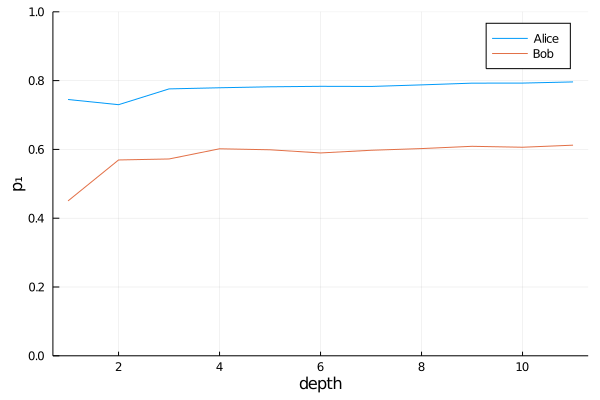

In [11]:
plot_p1(Agent("Alice", 0.75, 0.75), Agent("Bob", 0.45, 0.75))

### Bob Chases Alice, Alice Avoids Bob

Depending on how strong are the preference of Bob to meet Alice, and of Alice to avoid Bob, their behaviors may either converge to an equilibrium, or oscillate infinitely no matter how deep they deliberate.

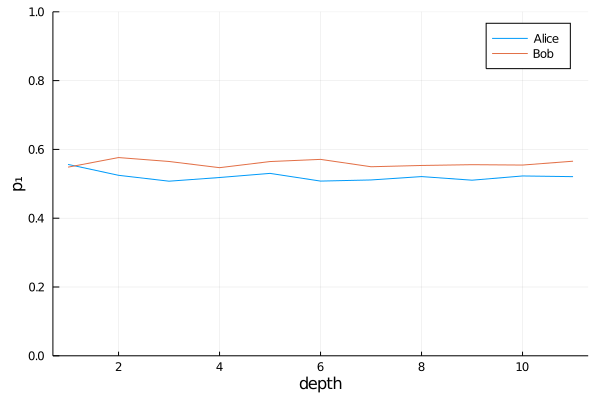

In [12]:
plot_p1(Agent("Alice", 0.55, 0.25), Agent("Bob", 0.55, 0.75))

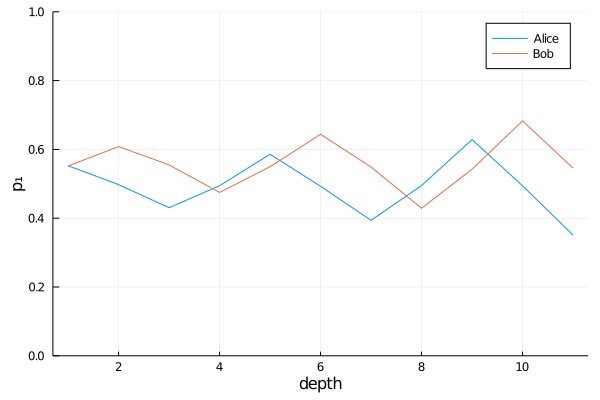

In [13]:
plot_p1(Agent("Alice", 0.55, 0.1), Agent("Bob", 0.55, 0.9))

### Bob and Alice Avoid Each Other

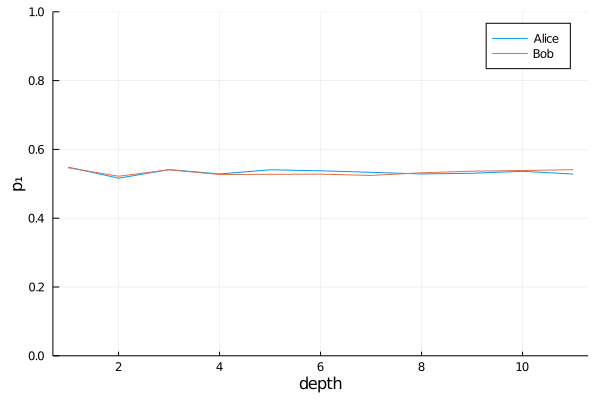

In [14]:
plot_p1(Agent("Alice", 0.55, 0.25), Agent("Bob", 0.55, 0.25))

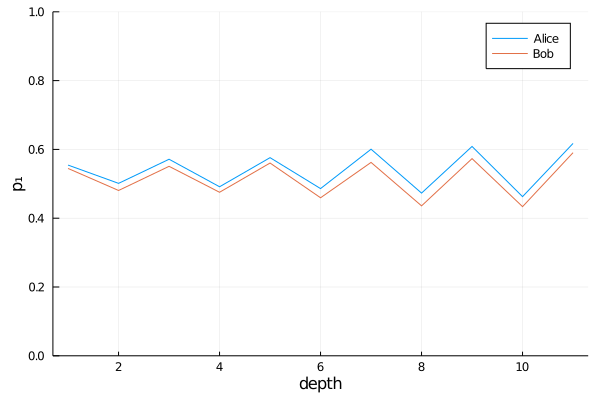

In [15]:
plot_p1(Agent("Alice", 0.55, 0.1), Agent("Bob", 0.55, 0.1))

Beyond a certain level of mutual despisal, it is hard to behave reasonably. One tends to make self-contradictory moves, and they do not help the least.

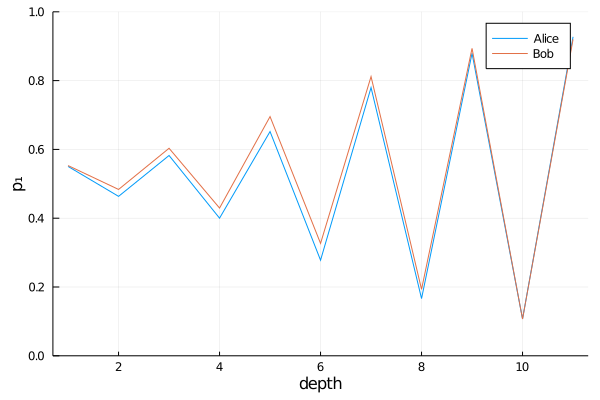

In [16]:
plot_p1(Agent("Alice", 0.55, 0.05), Agent("Bob", 0.55, 0.05))

### Analytical Model

The fable of Bob and Alice is simple enough to analyze using an analytical model, without resorting to approximate inference.  In general though, the posterior distribution does not have an analytical form.

In [17]:
@memoize function anagent(me::Agent, buddy::Agent, depth=0)
    p = me.p1
    if depth > 0
        q = anagent(buddy, me, depth-1)
        u1 = log(p) + logp(me, q, true)
        u2 = log(1-p) + logp(me, q, false)
        p = exp(u1)/(exp(u1) + exp(u2))
    end
    p
end

anagent (generic function with 2 methods)

For comparison, the plots obtained using Gen are reproduced here using the analytical model. 

#### Bob and Alice Want to Meet 

##### Bob and Alice Like the Same Bar

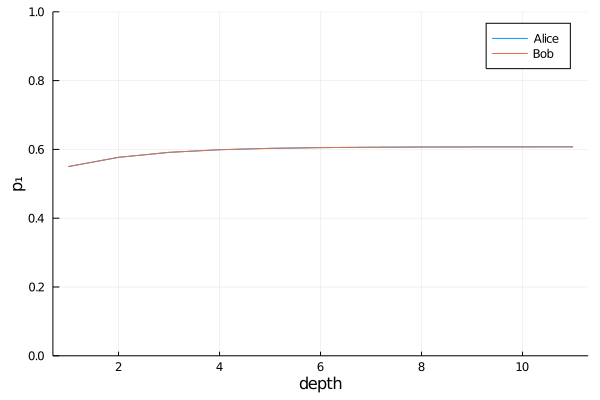

In [18]:
plot_p1(Agent("Alice", 0.55, 0.75), Agent("Bob", 0.55, 0.75), agent=anagent, at="ana")

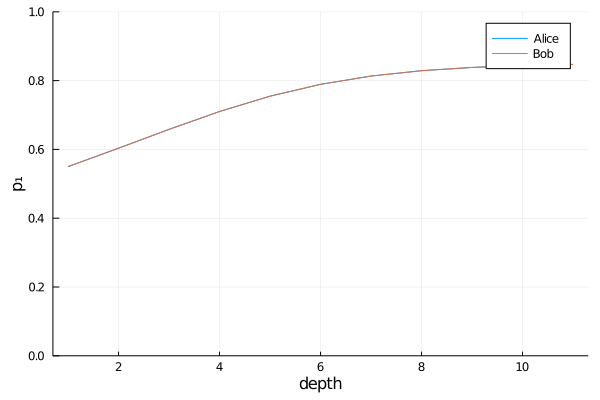

In [19]:
plot_p1(Agent("Alice", 0.55, 0.9), Agent("Bob", 0.55, 0.9), agent=anagent, at="ana")

##### Bob and Alice like different bars

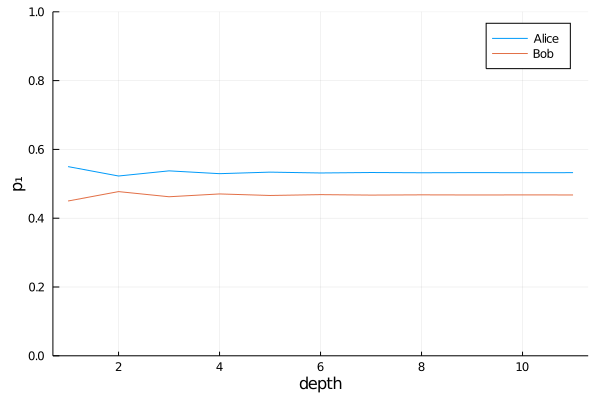

In [20]:
plot_p1(Agent("Alice", 0.55, 0.75), Agent("Bob", 0.45, 0.75), agent=anagent, at="ana")

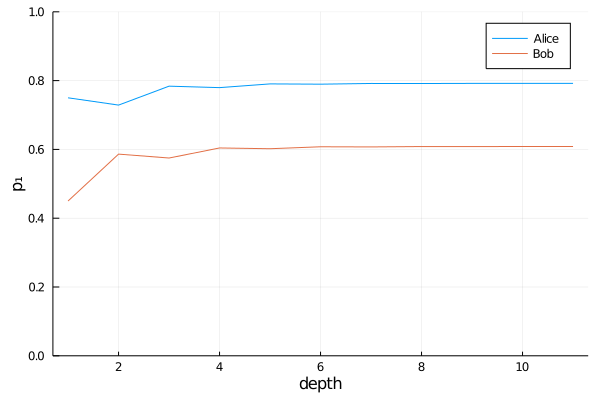

In [21]:
plot_p1(Agent("Alice", 0.75, 0.75), Agent("Bob", 0.45, 0.75), agent=anagent, at="ana")

#### Bob Chases Alice, Alice Avoids Bob

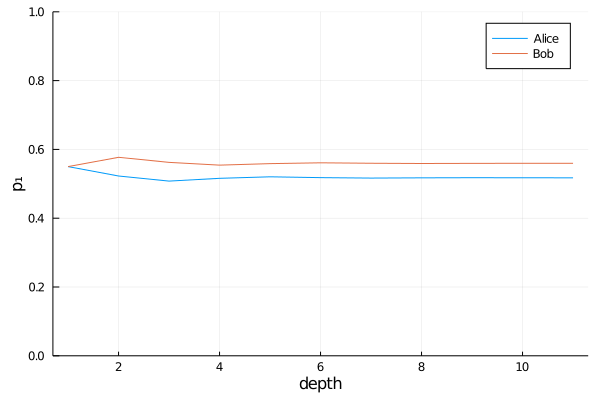

In [22]:
plot_p1(Agent("Alice", 0.55, 0.25), Agent("Bob", 0.55, 0.75), agent=anagent, at="ana")

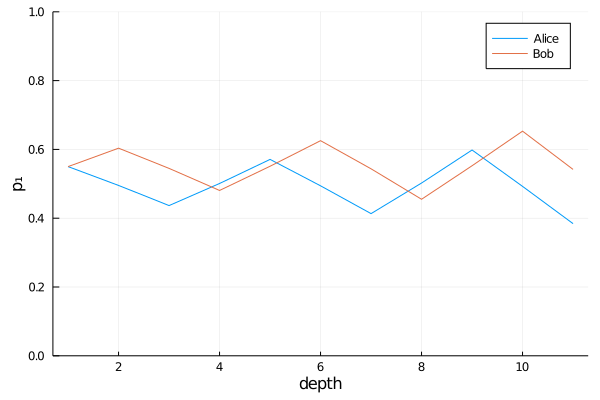

In [23]:
plot_p1(Agent("Alice", 0.55, 0.1), Agent("Bob", 0.55, 0.9), agent=anagent, at="ana")

#### Bob and Alice Avoid Each Other

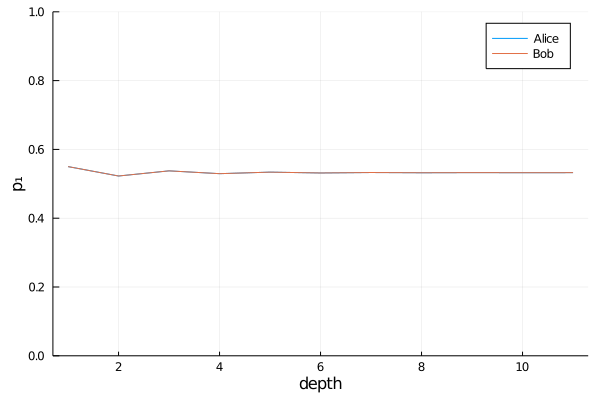

In [24]:
plot_p1(Agent("Alice", 0.55, 0.25), Agent("Bob", 0.55, 0.25), agent=anagent, at="ana")

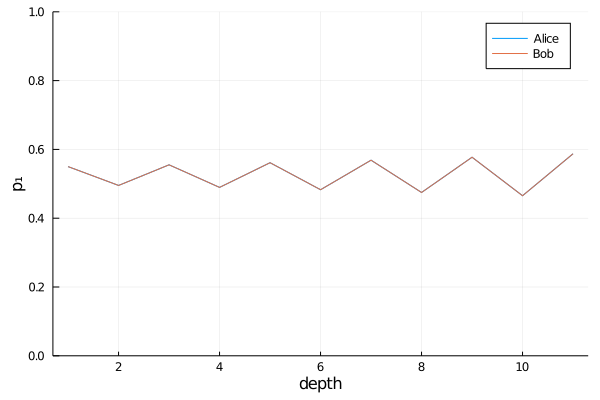

In [25]:
plot_p1(Agent("Alice", 0.55, 0.1), Agent("Bob", 0.55, 0.1), agent=anagent, at="ana")

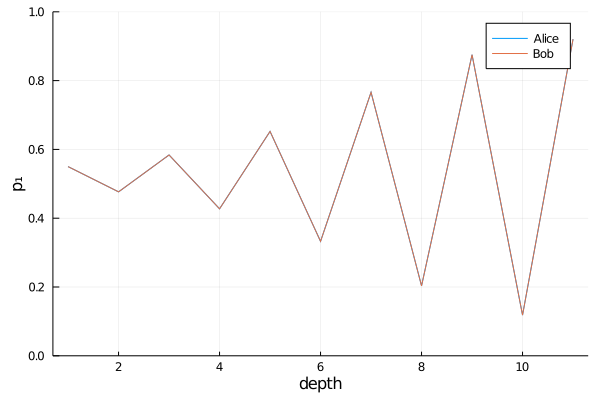

In [26]:
plot_p1(Agent("Alice", 0.55, 0.05), Agent("Bob", 0.55, 0.05), agent=anagent, at="ana")